In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline
# %matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import memory as mem   
from feedforward import Feedforward

## Helper Functions

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

# DQN

Complete the implemenation of DQN with a main Q-network and a target Q-network

In [4]:
""" Q Network, input: observations, output: q-values for all actions """
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, 
                 hidden_sizes=[100,100], learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, 
                         hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        # The L1 loss is often easier for choosing learning rates etc than for L2 (MSELoss)
        #  Imagine larger q-values (in the hundreds) then an squared error can quickly be 10000!, 
        #  whereas the L1 (absolute) error is simply in the order of 100. 
        self.loss = torch.nn.SmoothL1Loss()
        
    def fit(self, observations, actions, targets):
        """
        Train the Q-network on a batch of transitions
        Args:
            observations: Batch of states
            actions: Batch of actions taken
            targets: Target Q-values for the actions taken
        Returns:
            The loss value for this training step
        """
        self.optimizer.zero_grad()
        
        # Get the current Q-values for the actions taken
        current_q = self.Q_value(observations, actions)
        
        # Convert targets to tensor if necessary
        if not isinstance(targets, torch.Tensor):
            targets = torch.tensor(targets, dtype=torch.float32)
            
        # Compute the loss between current Q-values and targets
        loss = self.loss(current_q, targets)
        
        # Backpropagate and update weights
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def Q_value(self, observations, actions):
        """
        Compute Q-values for specific state-action pairs
        Args:
            observations: Batch of states
            actions: Batch of actions to evaluate
        Returns:
            Q-values for the given state-action pairs
        """
        # Get all Q-values for each state
        q_values = self.forward(observations)
        
        # Use gather to select the Q-values for the specific actions
        # actions needs to be reshaped to [batch_size, 1] for gather
        actions = actions.reshape(-1, 1)
        selected_q_values = q_values.gather(1, actions)
        
        return selected_q_values.squeeze()

    
    def maxQ(self, observations):
        """
        Compute the maximum Q-value for each state
        Args:
            observations: Batch of states
        Returns:
            Maximum Q-value for each state
        """
        # Get all Q-values
        q_values = self.forward(observations)
        
        # Get maximum Q-value for each state
        max_q_values, _ = torch.max(q_values, dim=-1)
        
        return max_q_values

    
    def greedyAction(self, observations):
        # this computes the greedy action
        return np.argmax(self.predict(observations), axis=-1)

In [5]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.05,            # Epsilon in epsilon greedy policies                        
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002, 
            # add additional parameters here        
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
        
        # Initialize Q networks (main and target)
        observation_dim = observation_space.shape[0]
        self.Q = QFunction(
            observation_dim=observation_dim,
            action_dim=self._action_n,
            hidden_sizes=self._config["hidden_sizes"],
            learning_rate=self._config["learning_rate"],
        )
        
        # Initialize target network with same architecture
        self.Q_target = QFunction(
            observation_dim=observation_dim,
            action_dim=self._action_n,
            hidden_sizes=self._config["hidden_sizes"],
            learning_rate=self._config["learning_rate"],
        )
        
        # Initialize target network with same weights as main network
        self._update_target_net()
        
        self.train_iter = 0

            
    def _update_target_net(self):        
        """Copy parameters from main Q network to target Q network"""
        self.Q_target.load_state_dict(self.Q.state_dict())
    
    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        """
        Train the DQN agent on batches of experience.
        Args:
            iter_fit: Number of training iterations
        Returns:
            List of loss values for each training iteration
        """
        losses = []
        
        # Update target network if needed
        if self.train_iter % self._config["target_update_freq"] == 0:
            self._update_target_net()
        
        for i in range(iter_fit):
            # Sample batch of transitions
            batch = self.buffer.sample(batch=self._config["batch_size"])
            
            # Extract SARS' components from transitions
            # Assuming transitions are stored as (state, action, reward, next_state, done)
            states = torch.tensor(np.vstack([t[0] for t in batch]), dtype=torch.float32)
            actions = torch.tensor([t[1] for t in batch], dtype=torch.long)
            rewards = torch.tensor([t[2] for t in batch], dtype=torch.float32)
            next_states = torch.tensor(np.vstack([t[3] for t in batch]), dtype=torch.float32)
            dones = torch.tensor([t[4] for t in batch], dtype=torch.float32)
            
            # Compute target Q values
            with torch.no_grad():  # Don't compute gradient info for target network
                # Get maximum Q value for next states using target network
                next_q_values = self.Q_target.maxQ(next_states)
                
                # Compute target using Bellman equation
                # target = r + gamma * max_a' Q(s', a') for non-terminal states
                # target = r for terminal states
                targets = rewards + (1 - dones) * self._config["discount"] * next_q_values
            
            # Train the network
            fit_loss = self.Q.fit(states, actions, targets)
            losses.append(fit_loss)
            
            self.train_iter += 1
            
        return losses


## Test in Env

In [6]:
env_name = 'Pendulum-v1'
# env_name = 'CartPole-v1'

env = gym.make(env_name)
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(5)
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
[(-1.0, 1.0), (-1.0, 1.0), (-8.0, 8.0)]


In [7]:
q_agent = DQNAgent(
    o_space, ac_space, discount=0.95, eps=0.2,
    hidden_sizes=[8,8], target_update_freq=15, learning_rate=0.00005,
    batch_size=64
)

In [8]:
ob,_info = env.reset()
q_agent.Q.predict(ob)

array([-0.12028004,  0.10085469, -0.42413336,  0.52512014, -0.28168952],
      dtype=float32)

Train the agent!

In [9]:
stats = []
losses = []

In [10]:
max_episodes=400
max_steps=300 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

1: Done after 300 steps. Reward: -2325.161273954552
21: Done after 300 steps. Reward: -2602.6137574293684
41: Done after 300 steps. Reward: -2644.274256973831
61: Done after 300 steps. Reward: -2881.721975146388
81: Done after 300 steps. Reward: -2397.2767682245235
101: Done after 300 steps. Reward: -2374.3794901650936
121: Done after 300 steps. Reward: -2660.4284657730564
141: Done after 300 steps. Reward: -2848.630460908007
161: Done after 300 steps. Reward: -2407.867042482147
181: Done after 300 steps. Reward: -2560.436864041461
201: Done after 300 steps. Reward: -2706.580648524904
221: Done after 300 steps. Reward: -2223.0559362281056
241: Done after 300 steps. Reward: -1955.1978573329936
261: Done after 300 steps. Reward: -2624.9894403632034
281: Done after 300 steps. Reward: -2110.2995864735335
301: Done after 300 steps. Reward: -1742.9866334335088
321: Done after 300 steps. Reward: -2122.1373212203707
341: Done after 300 steps. Reward: -2171.5456365023397
361: Done after 300 ste

Plot the training reward over time. Use the running_mean(array, window_size) to plot a smooth version 

In [13]:
def running_mean(array, window_size):
    """Calculate the running mean of an array using convolution."""
    if window_size > len(array):
        window_size = len(array)
    # Create a valid convolution window
    window = np.ones(int(window_size)) / float(window_size)
    # Use valid mode to avoid edge effects
    return np.convolve(array, window, 'valid')

def plot_training_progress(stats_np, losses_np, window_size=100):
    """Plot training progress with proper array handling."""
    # Extract rewards (assuming first column is rewards)
    rewards = stats_np[:, 0] if stats_np.ndim > 1 else stats_np
    
    # Create figure
    plt.figure(figsize=(12, 5))
    
    # Plot raw rewards
    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.3, color='gray', label='Raw rewards')
    
    # Calculate and plot smoothed rewards
    if len(rewards) >= window_size:
        smoothed = running_mean(rewards, window_size)
        # Create proper x-axis values for smoothed data
        x_smooth = np.arange(window_size-1, len(rewards))
        plt.plot(x_smooth, smoothed, 
                color='blue', linewidth=2, 
                label=f'Smoothed rewards (window={window_size})')
    
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses_np, color='orange', alpha=0.8, label='Training loss')
    plt.xlabel('Training step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


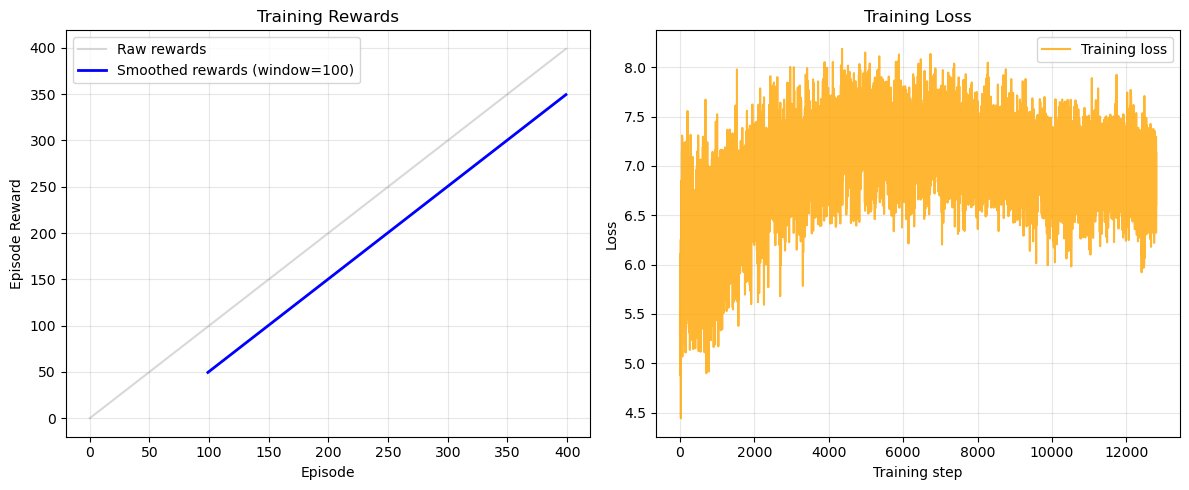

In [14]:
stats_np = np.asarray(stats)

losses_np = np.asarray(losses)

# Plot the training progress
plot_training_progress(stats_np, losses_np)


In [15]:
q_agent.buffer.size

100000

## Evaluate (without exploration)

Please look at the behavior for a small number of episodes

In [16]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [17]:
test_stats = []
episodes=50
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])        

Evaluate mean and standard deviation of performance 

(for the Pendulum: an average return around -30 or better should be achieved)

(for the CartPendulum it is possible to get 200)

In [18]:
def evaluate_performance(stats_np, losses_np):
    """Calculate performance statistics from training data."""
    # Extract rewards from stats (assuming first column is rewards)
    rewards = stats_np[:, 0]
    
    # Overall statistics
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Last 100 episodes statistics
    last_100_rewards = rewards[-100:]
    mean_last_100 = np.mean(last_100_rewards)
    std_last_100 = np.std(last_100_rewards)
    
    # Mean and std of losses
    mean_loss = np.mean(losses_np)
    std_loss = np.std(losses_np)
    
    # Print results
    print("\nPerformance Statistics:")
    print("-" * 30)
    print(f"Overall Performance:")
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"\nLast 100 Episodes:")
    print(f"Mean Reward: {mean_last_100:.2f} ± {std_last_100:.2f}")
    print(f"\nTraining Loss:")
    print(f"Mean Loss: {mean_loss:.4f} ± {std_loss:.4f}")
    
    return {
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'mean_last_100': mean_last_100,
        'std_last_100': std_last_100,
        'mean_loss': mean_loss,
        'std_loss': std_loss
    }

# Example usage:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
performance_stats = evaluate_performance(stats_np, losses_np)



Performance Statistics:
------------------------------
Overall Performance:
Mean Reward: 199.50 ± 115.47

Last 100 Episodes:
Mean Reward: 349.50 ± 28.87

Training Loss:
Mean Loss: 6.9758 ± 0.4617


# Visualize

Visualization of the value function.

In [24]:
def plot_max_q_values(q_function, env, resolution=10):
    """
    Plot the maximum Q-values across the state space.
    
    Args:
        q_function: The trained Q-function
        env: The environment (used to get state space bounds)
        resolution: Number of points to evaluate along each dimension
    """
    # Get state space bounds
    low = env.observation_space.low
    high = env.observation_space.high
    
    # Create grid of states
    x = np.linspace(low[0], high[0], resolution)
    y = np.linspace(low[1], high[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    # Calculate max Q values for each state
    Z = np.zeros_like(X)
    for i in range(resolution):
        for j in range(resolution):
            state = np.array([X[i,j], Y[i,j]])
            # Convert state to tensor
            state_tensor = torch.tensor(state.reshape(1, -1), dtype=torch.float32)
            # Get maxQ value for this state
            with torch.no_grad():  # No need to track gradients for visualization
                Z[i,j] = q_function.maxQ(state_tensor).cpu().numpy()
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot max Q values
    plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
    colorbar = plt.colorbar(label='Max Q-Value')
    
    # Customize the plot
    plt.title('Maximum Q-Values Across State Space')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    
    # Add a grid
    plt.grid(True, alpha=0.3)
    
    # Optional: Add text with min/max values
    plt.text(0.02, 1.02, f'Min Q: {Z.min():.2f}', transform=plt.gca().transAxes)
    plt.text(0.85, 1.02, f'Max Q: {Z.max():.2f}', transform=plt.gca().transAxes)
    
    plt.show()


In [25]:
plot_max_q_values(q_agent.Q, env)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 3x8)

## Pendulum Env

Observation space:

0 angle

1 angular velocity

Do that for the pendulum function. Does it look like you expect?

Do that for the pendulum function. Does it look like you expect

## Cartpole Env

Observation space:
 
0       Cart Position             -4.8                    4.8

1       Cart Velocity             -Inf                    Inf

2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)

3       Pole Angular Velocity     -Inf                    Inf

Try to adapt the plotting function that it also works in higher input spaces where all other inputs are 0

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=2, 
                       label_dim1="Cart Pos", label_dim2="Pole Angle")

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=0, plot_dim2=1, 
                       label_dim1="Cart Pos", label_dim2="Cart Vel")

In [ ]:
figQ = plot_Q_function_generic(q_agent.Q, input_dims=o_space.shape[0], plot_dim1=2, plot_dim2=3, 
                       label_dim1="Pol Angle", label_dim2="Pole Vel")

In [ ]:
%matplotlib notebook

In [ ]:
# env_name = 'Acrobot-v1'
# env_name = 'MountainCar-v0'
# env_name = 'LunarLander-v2'